In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer,OneHotEncoder,StandardScaler
from sklearn.model_selection import FixedThresholdClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [5]:
!pip install -U scikit-learn -q 
#v 1.5.0

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sim-tools 0.3.3 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [ ]:
## RESTART RUNTIME!!!!!!!!!!!!!!!!!!!!

In [ ]:
path = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
df = pd.read_csv(path,
                names=["id","diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean",
                        "compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean",
                        "radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se",
                        "concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst","perimeter_worst",
                        "area_worst","smoothness_worst","compactness_worst","concavity_worst","concave points_worst","symmetry_worst",
                        "fractal_dimension_worst"])

df

<Axes: >

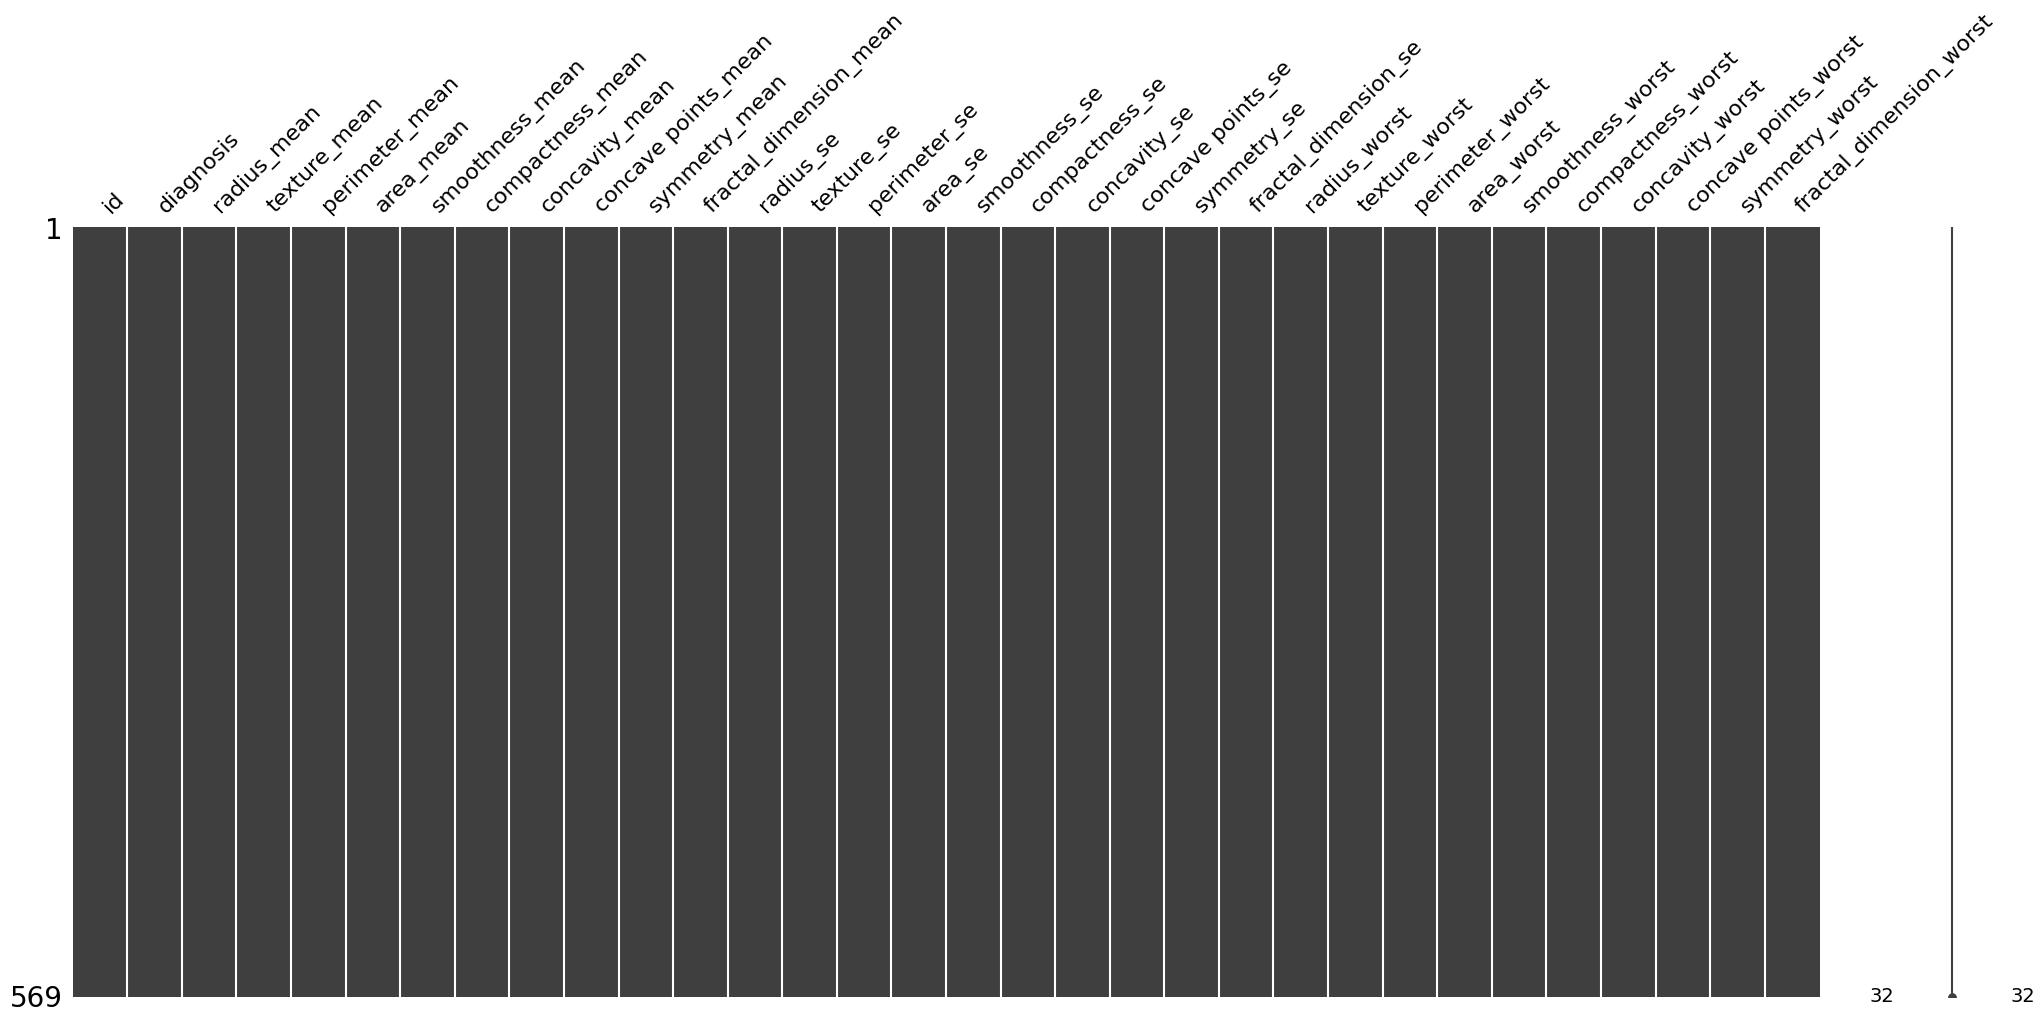

In [14]:
import missingno as msno
msno.matrix(df)

In [3]:
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [4]:
## TARGET NUMERICAL
df['diagnosis'] = df['diagnosis'].map({'B':0,'M':1})

In [5]:
#STEP 0 FILTERING
#remove features not useful
features_to_remove = ['id']
df_clean = df.drop(features_to_remove, axis=1)

In [6]:
# STEP 1 - TRAIN TEST SPLITTING
#Feature matrix and target vector
X = df_clean.drop(['diagnosis'], axis=1) # matrice Features
y = df_clean['diagnosis']                #Target

## Simple Imputer
https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

Il SimpleImputer è utilizzato per gestire i valori mancanti (NaN) all'interno dei dati. Nella tua pipeline, viene utilizzato per imputare i valori mancanti nelle feature numeriche, sostituendoli con la mediana dei valori presenti in quella colonna.

Ad esempio, supponiamo di avere una feature numerica come l'età di una persona e alcuni valori sono mancanti. Utilizzando SimpleImputer(strategy='median'), verranno sostituiti i valori mancanti con la mediana dell'età di tutte le altre persone.

Questo aiuta a mantenere la completezza dei dati durante l'analisi, poiché molti algoritmi di machine learning non possono gestire direttamente i valori mancanti.

- Se impostato su "mean", sostituisce i valori mancanti utilizzando la media lungo ciascuna colonna. Può essere utilizzato solo con dati numerici.

- Se impostato su "median", sostituisce i valori mancanti utilizzando la mediana lungo ciascuna colonna. Può essere utilizzato solo con dati numerici.

- Se impostato su "most_frequent", sostituisce i valori mancanti utilizzando il valore più frequente lungo ciascuna colonna. Può essere utilizzato con dati di tipo stringa o numerici. Se ci sono più valori più frequenti, viene restituito solo il più piccolo.

- Se impostato su "constant", sostituisce i valori mancanti con il valore specificato in fill_value. Può essere utilizzato con dati di tipo stringa o numerici.



In [7]:
X.columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [8]:
## dividiamo automaticamente le features numeriche da quelle categoriche

numerical_features = [x for x, dtype in zip(X.columns, X.dtypes) if dtype.kind in ['i','f'] ]
categorical_features = [x for x, dtype in zip(X.columns, X.dtypes) if dtype.kind not in ['i','f']]

print('Numerical : ' + str(numerical_features))
print('Categorical : ' + str(categorical_features))

Numerical : ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
Categorical : []


In [9]:
## Parte di processingdata: Cleaning, fill Nan + OHE
Preprocessor = make_column_transformer(
                                        (make_pipeline(
                                        SimpleImputer(strategy = 'median'),
                                        KBinsDiscretizer(n_bins=3)), numerical_features),

                                        (make_pipeline(
                                        #FunctionTransformer(lambda x: np.where(x == 'n.d.', np.nan, x)),
                                        SimpleImputer(strategy = 'constant', fill_value = 'missing'),
                                        OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features)
                                        )

In [10]:
scaler = StandardScaler()

best_classifier = RandomForestClassifier(n_estimators=100,random_state=667)
threshold = 0.27

classifier_th = FixedThresholdClassifier(best_classifier,
                                        threshold=threshold,
                                        response_method="predict_proba")

In [11]:
model_pipe = Pipeline([
                       ('Preprocessing features', Preprocessor),
                       ('Scaling and standadize data', scaler),
                       ('Classifier', classifier_th)
                      ])
model_pipe

Pipeline(steps=[('Preprocessing features',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=3))]),
                                                  ['radius_mean',
                                                   'texture_mean',
                                                   'perimeter_mean',
                                                   'area_mean',
                                                   'smoothness_mean',
                                                   'compactness_mean',
                                                   'concavity_mean',
                                                   'concave points_mean',
                                                   'symmetry_me...
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('Scaling and standadize data', StandardScaler()),
                ('Classifier',
                 FixedThresholdClassifier(estimator=RandomForestClassifier(random_state=667),
                                          response_method='predict_proba',
                                          threshold=0.27))])

In [12]:
cross_val_scores = cross_val_score(model_pipe, X, y, cv=5)
print(cross_val_scores)

# Calcola la media e la deviazione standard dei punteggi
mean_score = np.mean(cross_val_scores)
std_score = np.std(cross_val_scores)

print(f"Mean cross-validation score:{mean_score:.2f}")
print(f"Standard deviation of cross-validation scores:{std_score:.2f}")

[0.92105263 0.94736842 0.96491228 0.92982456 0.9380531 ]
Mean cross-validation score:0.94
Standard deviation of cross-validation scores:0.02


##Fit the model with entire dataset

<img src='https://frenzy86.s3.eu-west-2.amazonaws.com/python/cross.png' width=600>


In [13]:
model_pipe.fit(X, y)

Pipeline(steps=[('Preprocessing features',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=3))]),
                                                  ['radius_mean',
                                                   'texture_mean',
                                                   'perimeter_mean',
                                                   'area_mean',
                                                   'smoothness_mean',
                                                   'compactness_mean',
                                                   'concavity_mean',
                                                   'concave points_mean',
                                                   'symmetry_me...
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('Scaling and standadize data', StandardScaler()),
                ('Classifier',
                 FixedThresholdClassifier(estimator=RandomForestClassifier(random_state=667),
                                          response_method='predict_proba',
                                          threshold=0.27))])

In [14]:
y_pred_tot = model_pipe.predict(X)

In [15]:
from sklearn.metrics import classification_report

classification_report(y,y_pred_tot )

classification_report_result = classification_report(y, y_pred_tot)
print(classification_report_result)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       357
           1       0.99      1.00      0.99       212

    accuracy                           0.99       569
   macro avg       0.99      1.00      0.99       569
weighted avg       0.99      0.99      0.99       569



## Prediction of single observation

In [19]:
data = X.iloc[0].to_dict()
data

{'radius_mean': 17.99,
 'texture_mean': 10.38,
 'perimeter_mean': 122.8,
 'area_mean': 1001.0,
 'smoothness_mean': 0.1184,
 'compactness_mean': 0.2776,
 'concavity_mean': 0.3001,
 'concave points_mean': 0.1471,
 'symmetry_mean': 0.2419,
 'fractal_dimension_mean': 0.07871,
 'radius_se': 1.095,
 'texture_se': 0.9053,
 'perimeter_se': 8.589,
 'area_se': 153.4,
 'smoothness_se': 0.006399,
 'compactness_se': 0.04904,
 'concavity_se': 0.05373,
 'concave points_se': 0.01587,
 'symmetry_se': 0.03003,
 'fractal_dimension_se': 0.006193,
 'radius_worst': 25.38,
 'texture_worst': 17.33,
 'perimeter_worst': 184.6,
 'area_worst': 2019.0,
 'smoothness_worst': 0.1622,
 'compactness_worst': 0.6656,
 'concavity_worst': 0.7119,
 'concave points_worst': 0.2654,
 'symmetry_worst': 0.4601,
 'fractal_dimension_worst': 0.1189}

In [21]:
input_df = pd.DataFrame([data])
res = model_pipe.predict(input_df).astype(int)[0]
print(res)

classes = {0:'B',
           1:'M'
           }

y_pred = classes[res]
y_pred

1


'M'

In [23]:
import joblib

joblib.dump(model_pipe,'binarypipe.pkl')

['binarypipe.pkl']

## Load model .pkl

In [24]:
import joblib

model_pipe = joblib.load('binarypipe.pkl')
print('Model loaded successfully')

Model loaded successfully


In [25]:
model_pipe

Pipeline(steps=[('Preprocessing features',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=3))]),
                                                  ['radius_mean',
                                                   'texture_mean',
                                                   'perimeter_mean',
                                                   'area_mean',
                                                   'smoothness_mean',
                                                   'compactness_mean',
                                                   'concavity_mean',
                                                   'concave points_mean',
                                                   'symmetry_me...
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('Scaling and standadize data', StandardScaler()),
                ('Classifier',
                 FixedThresholdClassifier(estimator=RandomForestClassifier(random_state=667),
                                          response_method='predict_proba',
                                          threshold=0.27))])